# Settings and configuration

Run the first three cells to assure compatibility and reproductibility of the code making sure all libraries can be accessed. <br>
Make sure you define your working directory in code cell 2, line 19. <br> <br>
IMPORTANT: <br>- If using Google Drive, un-hash line 17 in code cell 2 ('configure data directory'), if not, add a hash at the beginning of the line. <br>- After running the first cell 'Environment bootstrap' restart the session. <br>- Many cells need outputs from previous cells (except the Model selection and validation section in which each cell can run independetly but needs outputs from previous sections). Make sure you execute them sequentially or press 'run all' after executing the first cell and restarting the session.

In [1]:
'''
────────────────────────────────────────────────────────────────────────────────
ENVIRONMENT BOOTSTRAP — works both locally and on Google Colab
────────────────────────────────────────────────────────────────────────────────
'''

import subprocess, sys, os, shlex, json, textwrap

COLAB = "google.colab" in sys.modules

if COLAB:
    print("Running on Colab: installing pinned dependencies…")

    subprocess.run(["pip", "install", "-q", "--upgrade", "pip"], check=True)

    subprocess.run(["pip", "uninstall", "-y", "-q", "spacy", "thinc", "scipy"], check=False)

    pkgs = [
        "numpy<2",
        "pandas==2.2.*",
        "scikit-learn==1.5.*",
        "trimesh==4.4.*",
        "joblib==1.4.*",
        "tqdm==4.67.1",
        "open3d==0.18.0",
        "scipy==1.13.*"
    ]
    subprocess.run(["pip", "install", "-q"] + pkgs, check=True)

    # Confirm the environment snapshot for reproducibility
    subprocess.run(["pip", "freeze", "--all", "--exclude-editable"], check=True)

    # Restart the kernel after installing packages to ensure compatibility
    print("\nRestarting kernel to ensure package compatibility...")

    print("Please manually restart the runtime (Runtime -> Restart session) if prompted or if you encounter issues.")
else:
    print("Running locally – assuming you manage the env via Conda/Poetry/etc")

Running on Colab: installing pinned dependencies…

Restarting kernel to ensure package compatibility...
Please manually restart the runtime (Runtime -> Restart session) if prompted or if you encounter issues.


In [2]:
# ───────────────────────────────────────────────────
#  Configure data directory (local/GDrive)
# ───────────────────────────────────────────────────
from pathlib import Path
import os

# --- READ CAREFULLY ---

# Option 1 – leave CUSTOM_DIR = ""  and the notebook will use:
#   • /content  on Colab
#   • the current working directory on desktop
#
# Option 2 – set CUSTOM_DIR to an absolute path
#   e.g.  CUSTOM_DIR = "/content/drive/MyDrive/3Dmodelst"
#
# IMPORTANT: If running on Colab + Google Drive, first run:
from google.colab import drive; drive.mount('/content/drive/')

CUSTOM_DIR = "/content/drive/MyDrive/3Dmodels"   # ← EDIT ME if your 3D models are elsewhere

if CUSTOM_DIR:
    BASE_DIR = Path(CUSTOM_DIR).expanduser().resolve()
else:
    default_root = "/content" if "google.colab" in str(get_ipython()) else "."
    BASE_DIR = Path(os.environ.get("GRAIN_BASE_DIR", default_root)).resolve()

os.environ["GRAIN_BASE_DIR"] = str(BASE_DIR)
print("📁 BASE_DIR set to", BASE_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
📁 BASE_DIR set to /content/drive/MyDrive/3Dmodels


In [3]:
# ───────────────────────────────────────────────────
# Seed configuration
# ───────────────────────────────────────────────────
import os, random, numpy as np
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
try:
    import torch
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
except ImportError:
    pass
print("Random seeds fixed to", SEED)

Random seeds fixed to 42


# 3D shape identification algorithm

#### Extract the measures from the 3D mesh files
Extracted measures will be written to a csv file within the CUSTOM_DIR defined above. <br>Specify the csv file name to store the extracted measures (line 244). This file will be stored in the same folder the files are stored. <br>Other parameters, such as the number of sections and the number of Fourier descriptors can also be modified (marked within the script). <br> <br> Please, note that folder path is also included in the measures output csv file. This is intended for the user to be able to recover the class at a latter stage, assuming that the models are divided by subfolders according to class within the main folder.

In [ ]:
'''
────────────────────────────────────────────────────────────────────────────────
3-D MODEL FEATURE EXTRACTOR
────────────────────────────────────────────────────────────────────────────────
'''

import os, glob, math, warnings
from joblib import Parallel, delayed
from tqdm import tqdm
from pathlib import Path
import numpy as np
import pandas as pd
import trimesh
from scipy.spatial import ConvexHull, QhullError
from sklearn.decomposition import PCA
from numpy.fft import fft

# ───────────────────────────────────────────────────
#  1. CONFIGURATION
# ───────────────────────────────────────────────────
N_SECTIONS       = 9           # ← EDIT if needed
N_FOURIER_DESCR  = 10          # ← EDIT if needed
SLICE_EPS        = 1e-8
VERBOSE          = True
N_WORKERS        = -1
TQDM_BAR         = True

# ───────────────────────────────────────────────────
#  2. Geometry helpers
# ───────────────────────────────────────────────────
def _convex_hull_2d(points):
    try:
        return ConvexHull(points).volume
    except QhullError:
        return 0.0

def _ordered_hull(points):
    try:
        hull = ConvexHull(points, qhull_options='QJ')
        return points[hull.vertices]
    except QhullError:
        return points

def _safe_ratio(a, b, default=np.nan):
    return a / b if abs(b) > SLICE_EPS else default

# ───────────────────────────────────────────────────
#  3. Feature blocks
# ───────────────────────────────────────────────────
def _compute_cross_sections(v, axis, n=N_SECTIONS):
    coord = v[:, axis]
    min_v, max_v = coord.min(), coord.max()
    if abs(max_v - min_v) < SLICE_EPS:
        return [0.]*n
    edges = np.linspace(min_v, max_v, n+1)
    areas = []
    for lo, hi in zip(edges[:-1], edges[1:]):
        mask = (coord >= lo) & (coord < hi)
        sect = v[mask]
        if len(sect) < 3:
            areas.append(0.)
            continue
        proj = np.delete(sect, axis, axis=1)
        areas.append(_convex_hull_2d(proj))
    return areas

def _fourier_descriptors_2d(contour, k=N_FOURIER_DESCR):
    if len(contour) < 3:
        return np.zeros(k)
    centred = contour - contour.mean(axis=0)
    coeffs  = fft(centred[:,0] + 1j*centred[:,1])
    return np.abs(coeffs[:k])

def _global_fourier(v, k=N_FOURIER_DESCR):
    descr=[]
    for a,b in [(0,1),(0,2),(1,2)]:
        hull_pts = _ordered_hull(v[:,[a,b]])
        descr.extend(_fourier_descriptors_2d(hull_pts, k))
    return np.array(descr)

def _section_fourier(v, axis, n=N_SECTIONS, k=N_FOURIER_DESCR):
    coord = v[:, axis]
    min_v, max_v = coord.min(), coord.max()
    if abs(max_v - min_v) < SLICE_EPS:
        return np.zeros(n*k)
    edges = np.linspace(min_v, max_v, n+1)
    descr = []
    for lo, hi in zip(edges[:-1], edges[1:]):
        mask = (coord >= lo) & (coord < hi)
        sect = v[mask]
        if len(sect) < 3:
            descr.extend([0.]*k)
            continue
        proj = np.delete(sect, axis, axis=1)
        descr.extend(_fourier_descriptors_2d(_ordered_hull(proj), k))
    return np.array(descr)

def _curvature_estimate(v):
    verts = v.reshape(-1,3)
    if len(verts) < 9:
        return np.nan
    angles=[]
    for i in range(0,len(verts)-2,3):
        p1,p2,p3 = verts[i:i+3]
        v1,v2 = p2-p1, p3-p1
        n1,n2 = np.linalg.norm(v1), np.linalg.norm(v2)
        if n1<SLICE_EPS or n2<SLICE_EPS: continue
        cosang = np.clip(np.dot(v1,v2)/(n1*n2), -1,1)
        angles.append(np.arccos(cosang))
    return np.mean(angles) if angles else np.nan

def _sphericity(vol, area):
    return (math.pi**(1/3)*(6*vol)**(2/3))/area if area>SLICE_EPS else np.nan

def extract_features(mesh):
    """Robust feature extractor — returns 1-D ndarray."""
    v = mesh.vertices
    dims = v.ptp(axis=0)
    # PCA
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pca = PCA(3).fit(v)

    var_ratio = pca.explained_variance_ratio_

    # 3-D convex hull
    try:
        hull3d = ConvexHull(v, qhull_options='QJ')
        vol, area = hull3d.volume, hull3d.area
    except QhullError:
        vol, area = np.nan, np.nan

    aspect   = [_safe_ratio(dims[0],dims[1]),
                _safe_ratio(dims[1],dims[2]),
                _safe_ratio(dims[0],dims[2])]
    elong    = _safe_ratio(dims.max(), dims.min())
    compact  = _safe_ratio(vol, np.linalg.norm(dims)**3)
    compact2 = _safe_ratio(vol, np.prod(dims))
    ecc      = math.sqrt(max(0, 1 - _safe_ratio(dims.min(),dims.max())**2))

    cs_x = _compute_cross_sections(v,0)
    cs_y = _compute_cross_sections(v,1)
    cs_z = _compute_cross_sections(v,2)

    vol_sa = _safe_ratio(vol, area)
    curv   = _curvature_estimate(v)

    f_global = _global_fourier(v)
    f_sec_x  = _section_fourier(v,0)
    f_sec_y  = _section_fourier(v,1)
    f_sec_z  = _section_fourier(v,2)

    sph       = _sphericity(vol,area)
    roundness = _safe_ratio(area, 4*math.pi*((3*vol)/(4*math.pi))**(2/3))

    return np.concatenate([
        dims,[vol,area],
        aspect,[elong,compact,compact2,ecc],
        cs_x,cs_y,cs_z,
        [vol_sa],var_ratio,pca.components_.flatten(),
        [curv],f_global,f_sec_x,f_sec_y,f_sec_z,
        [sph,roundness]
    ])

# ───────────────────────────────────────────────────
#  4. Column names (in sync with extract_features)
# ───────────────────────────────────────────────────
def make_column_names():
    cols=['Length','Width','Height','Volume','Surface Area',
          'Aspect XY','Aspect YZ','Aspect XZ',
          'Elongation','Compactness','Compactness_AABB','Eccentricity']
    cols+=[f'CS Area X{i+1}' for i in range(N_SECTIONS)]
    cols+=[f'CS Area Y{i+1}' for i in range(N_SECTIONS)]
    cols+=[f'CS Area Z{i+1}' for i in range(N_SECTIONS)]
    cols+=['Vol / SA']
    cols+=[f'PCA Var {i+1}' for i in range(3)]
    cols+=[f'PCA Comp {i+1}-{j+1}'
           for i in range(3) for j in range(3)]
    cols+=['Curvature']
    cols+=[f'F Global {pl}-{i+1}'
           for pl in ('XY','XZ','YZ') for i in range(N_FOURIER_DESCR)]
    for ax in 'XYZ':
        cols+=[f'F Section {ax}{s+1}-{i+1}'
               for s in range(N_SECTIONS) for i in range(N_FOURIER_DESCR)]
    cols+=['Sphericity','Roundness']
    return cols

# ───────────────────────────────────────────────────
#  5. Worker
# ───────────────────────────────────────────────────
def _process_one(path):
    try:
        mesh = trimesh.load(path, force='mesh', skip_materials=True, process=True)
        if not isinstance(mesh, trimesh.Trimesh):
            return None
        feats = extract_features(mesh)
        return feats, os.path.basename(path), os.path.dirname(path)
    except Exception as e:
        if VERBOSE:
            print(f"⚠️  {os.path.basename(path)} skipped: {e}")
        return None

# ───────────────────────────────────────────────────
#  6. Parallel driver
# ───────────────────────────────────────────────────
def process_folder(folder_path):
    stl_paths = glob.glob(os.path.join(folder_path, '**', '*.stl'), recursive=True)
    if VERBOSE:
        print(f"{len(stl_paths)} STL files queued …")

    iterator = tqdm(stl_paths, desc="Meshes") if TQDM_BAR else stl_paths

    results = Parallel(n_jobs=N_WORKERS, backend='loky', verbose=0)(
                delayed(_process_one)(p) for p in iterator)

    # keep only successful runs
    valid = [r for r in results if r is not None]
    if not valid:
        raise RuntimeError("No valid STL meshes were processed.")

    feats, names, folders = zip(*valid)
    features = np.vstack(feats)
    files    = list(zip(names, folders))
    return features, files

# ───────────────────────────────────────────────────
#  7. CSV export
# ───────────────────────────────────────────────────
def export_csv(features, file_info, out_path):
    df = pd.DataFrame(features, columns=make_column_names())
    df['File Name']   = [f for f,_ in file_info]
    df['Folder Path'] = [p for _,p in file_info]
    df['Class']       = ''
    df.to_csv(out_path, index=False)
    print(f"✓ CSV written to {out_path}")

# ───────────────────────────────────────────────────
#  8. MAIN
# ───────────────────────────────────────────────────
# Use BASE_DIR defined in the environment setup cell and the correct variable name CUSTOM_DIR
folder = Path(BASE_DIR) / CUSTOM_DIR
features, files = process_folder(folder)

out_csv = os.path.join(folder, "measures_file.csv")
export_csv(features, files, out_csv)

697 STL files queued …


Meshes: 100%|██████████| 697/697 [13:02<00:00,  1.12s/it]


✓ CSV written to /content/drive/MyDrive/3Dmodels/measures_file.csv


### Get information about the structure of your CSV
This will provide some info about the measures extracted, which can be useful to evaluate them at a later stage. The folder paths (printed towards the end of the report) can be used as an input for the following class assignation stage. <br> Provide the name the of csv file (CUSTOM_DIR defined above is assumed) with the measures you want to visualise (line 13) and (if required) the number of values to show per column (line 27).

In [ ]:
'''
────────────────────────────────────────────────────────────────────────────────
OBTAIN INFORMATION ABOUT THE EXTRACTED MEASURES' TABLE
────────────────────────────────────────────────────────────────────────────────
'''

import pandas as pd
from pathlib import Path

# ────────────────────────────────────────────
# 1. Load
# ────────────────────────────────────────────
CSV_PATH = Path(BASE_DIR) / "measures_file.csv"  # patched for portability

df = pd.read_csv(CSV_PATH)
print(f"\nLoaded {CSV_PATH.name}  →  {df.shape[0]:,} rows × {df.shape[1]:,} columns\n")

# ────────────────────────────────────────────
# 2. Basic info
# ────────────────────────────────────────────
df.info(max_cols=0, memory_usage='deep')
print()

# ────────────────────────────────────────────
# 3. Per-column unique-value peek
# ────────────────────────────────────────────
MAX_TO_SHOW = 20                           # show up to 20 values, EDIT if needed
for col in df.columns:
    uniq = pd.unique(df[col].dropna())
    n = len(uniq)
    print(f'• {col} — {n:,} unique value(s)')
    if n <= MAX_TO_SHOW:
        print('   ', uniq.tolist())
    else:
        head = uniq[:MAX_TO_SHOW // 2]
        tail = uniq[-MAX_TO_SHOW // 2:]
        print('    first →', head.tolist())
        print('    last  →', tail.tolist())
    print('-----------------------------------------------------')

# ────────────────────────────────────────────
# 4. Statistical summary of numeric columns
# ────────────────────────────────────────────
print("\nDescriptive stats (numeric columns):")
print(df.describe().T)


Loaded measures_file.csv  →  697 rows × 358 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Columns: 358 entries, Length to Class
dtypes: float64(356), object(2)
memory usage: 2.0 MB

• Length — 697 unique value(s)
    first → [6.148860216140747, 6.821313858032227, 6.2590765953063965, 6.495624303817749, 7.652698040008545, 5.690599918365479, 5.946630477905273, 6.401559591293335, 7.01071572303772, 6.667207479476929]
    last  → [7.283466577529907, 7.489495038986206, 7.338326692581177, 8.047457456588745, 6.767658233642578, 7.331537246704102, 7.775463342666626, 7.410788536071777, 8.209414958953857, 7.697190284729004]
-----------------------------------------------------
• Width — 697 unique value(s)
    first → [3.467974901199341, 3.412845492362976, 3.4062130451202397, 3.3804404735565186, 3.474920749664306, 3.122841238975525, 3.421176552772522, 3.3484489917755127, 3.452333450317383, 3.499829649925232]
    last  → [3.824836850166321, 3.752412676811218, 3.91

### Select the column and values within it to create the class values in the csv file 'class' column
ATENTION: START HERE when you have already configured the environment (by executing code cell 1, restarted the session, and executed code cells 1-3) and extracted the measures from the 3D files. There is no need to extract them again. Define the new classes for a different classification task. <br>Remember to use the output file name from this script in the following scripts by changing manually the name of the input files, so you are using the newly defined classes for classification. <br> <br>Use the information obtained above (towards the end of the report) to classify each unique path into a class for classification. <br> This cell uses the input specified in the previous cell. Please, select an intput file (resulting from the extractio nof measures) in line 20 and an output file (the new file with classes) in line 21. <br>The use of folder paths here is based on the assumption that the models were distributed in different folders (see notes to the first cell), each with one specific characteristic that defines the class, e.g.: 'Dundee\\6ROW Bere\\6ROW BERE Orkney'. If you have used another way to mark the class, please, specify it in the code below (line 22). <br> Please, note that the report above only shows the first and last 20 unique paths (in this case corresponding to classes definitions), if there are more paths you will have to increase the number of values to show in the previous cell.

In [4]:
"""
──────────────────────────────────────────────────────────────────────────────
  ADD CLASS LABELS TO THE MEASUREMENTS CSV
------------------------------------------------------------------------------
  Requires:
  · Select the file with the extracted measures
  · Manually define the table column used to define the class (Folder Path in this case)
  · Manually write the unique values of this column
  · Manually write the names of the new classes
  The output file with the new classes will need to be used in the next scripts
──────────────────────────────────────────────────────────────────────────────
"""

from pathlib import Path
import pandas as pd

# ────────────────────────────────────────────────────────────────────────────
#  1. USER SETTINGS
# ────────────────────────────────────────────────────────────────────────────
CSV_IN = Path(BASE_DIR) / "measures_file.csv"            # ← EDIT if needed
CSV_OUT  = CSV_IN.with_name("measures_origin.csv")         # ← EDIT if needed
FOLDER_COL = "Folder Path"                               # ← EDIT if needed

# Human-readable label dictionary (mix '/' or '\\' freely – it will be normalised)
CLASS_MAP_RAW = {
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Dundee/2ROW British"                       : "Dundee",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Dundee/2ROW Scottish"                      : "Dundee",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Dundee/6ROW Bere/6ROW BERE Orkney"         : "Dundee",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Dundee/6ROW Bere/6ROW BERE Unknown"        : "Dundee",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Dundee/6ROW Bere/6ROW BERE Western Isles"  : "Dundee",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Dundee/6ROW Scandinavian"                  : "Dundee",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Orkney/2ROW British"                       : "Orkney",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Orkney/2ROW Scottish"                      : "Orkney",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Orkney/6ROW Bere/6ROW BERE ORKNEY"         : "Orkney",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Orkney/6ROW Bere/6ROW BERE Unknown"        : "Orkney",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Orkney/6ROW Bere/6ROW BERE Western Isles"  : "Orkney",
    r"/content/drive/MyDrive/3Dmodels/oriented_SH/Orkney/6ROW Scandinavian"                  : "Orkney",
}

DEFAULT_LABEL = "??"              # what to write when a row is not in CLASS_MAP

# ────────────────────────────────────────────────────────────────────────────
#  2. LOAD AND NORMALISE PATH STRINGS
# ────────────────────────────────────────────────────────────────────────────
df = pd.read_csv(CSV_IN)
print(f"➜ Loaded {CSV_IN.name}  ({df.shape[0]} rows)")

# Normalise both the CSV column and the mapping keys to forward-slash form
df[FOLDER_COL] = df[FOLDER_COL].apply(lambda p: Path(p).as_posix())
CLASS_MAP = {Path(k).as_posix(): v for k, v in CLASS_MAP_RAW.items()}

# ────────────────────────────────────────────────────────────────────────────
#  3. ASSIGN CLASSES
# ────────────────────────────────────────────────────────────────────────────
df["Class"] = df[FOLDER_COL].map(CLASS_MAP).fillna(DEFAULT_LABEL)

# Report any unknown paths (helpful when new folders appear)
unknown = df.loc[df["Class"] == DEFAULT_LABEL, FOLDER_COL].unique()
if len(unknown):
    print(f"⚠  {len(unknown)} folder(s) were not in CLASS_MAP:")
    for p in unknown:
        print("   •", p)

# ────────────────────────────────────────────────────────────────────────────
#  4. SAVE
# ────────────────────────────────────────────────────────────────────────────
df.to_csv(CSV_OUT, index=False)
print(f"✓ CSV with class labels written to  {CSV_OUT}")

➜ Loaded measures_file.csv  (697 rows)
✓ CSV with class labels written to  /content/drive/MyDrive/3Dmodels/measures_origin.csv


### Select, execute, and validate the classifiers
Select the csv file with the extracted measures and the classes defined in the previous cell (line 60). <br>
Select the percentage of the total data available for testing purposes (from 0 to 1, recommended 0.20) in line 72. The number of trees for the Random Forest classifier can also be changed in line 82 (the validation section below includes code to calculate the best number of trees). All other data will be used to train the classifiers.


MODEL: RF
  CV accuracy : 0.7918 ± 0.0468
  Test accuracy: 0.7929

Classification report:
              precision    recall  f1-score   support

      Dundee     0.7794    0.7910    0.7852        67
      Orkney     0.8056    0.7945    0.8000        73

    accuracy                         0.7929       140
   macro avg     0.7925    0.7928    0.7926       140
weighted avg     0.7930    0.7929    0.7929       140



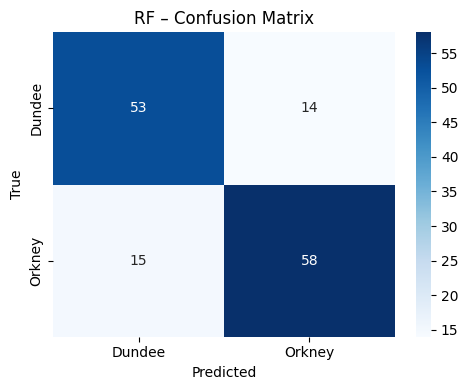

  Confusion matrix saved → /content/drive/MyDrive/3Dmodels/rf_cm.png

MODEL: GBM
  CV accuracy : 0.7972 ± 0.0418
  Test accuracy: 0.8071

Classification report:
              precision    recall  f1-score   support

      Dundee     0.7941    0.8060    0.8000        67
      Orkney     0.8194    0.8082    0.8138        73

    accuracy                         0.8071       140
   macro avg     0.8068    0.8071    0.8069       140
weighted avg     0.8073    0.8071    0.8072       140



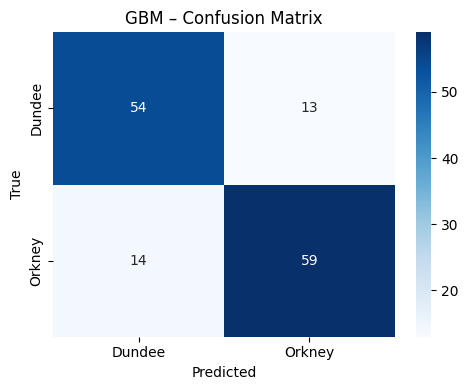

  Confusion matrix saved → /content/drive/MyDrive/3Dmodels/gbm_cm.png

MODEL: SVM
  CV accuracy : 0.8009 ± 0.0472
  Test accuracy: 0.8357

Classification report:
              precision    recall  f1-score   support

      Dundee     0.8438    0.8060    0.8244        67
      Orkney     0.8289    0.8630    0.8456        73

    accuracy                         0.8357       140
   macro avg     0.8363    0.8345    0.8350       140
weighted avg     0.8360    0.8357    0.8355       140



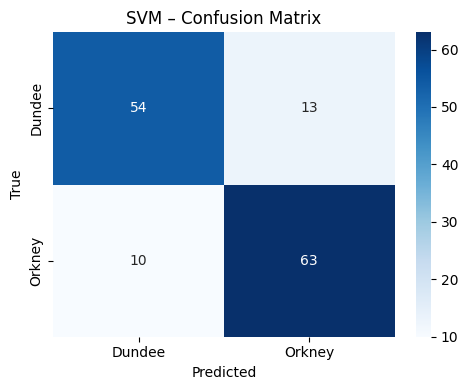

  Confusion matrix saved → /content/drive/MyDrive/3Dmodels/svm_cm.png

MODEL: KNN
  CV accuracy : 0.7109 ± 0.0457
  Test accuracy: 0.7429

Classification report:
              precision    recall  f1-score   support

      Dundee     0.8974    0.5224    0.6604        67
      Orkney     0.6832    0.9452    0.7931        73

    accuracy                         0.7429       140
   macro avg     0.7903    0.7338    0.7267       140
weighted avg     0.7857    0.7429    0.7296       140



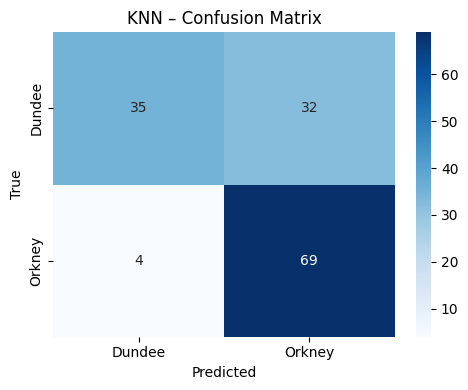

  Confusion matrix saved → /content/drive/MyDrive/3Dmodels/knn_cm.png

MODEL: LDA
  CV accuracy : 0.6554 ± 0.0592
  Test accuracy: 0.7500

Classification report:
              precision    recall  f1-score   support

      Dundee     0.7353    0.7463    0.7407        67
      Orkney     0.7639    0.7534    0.7586        73

    accuracy                         0.7500       140
   macro avg     0.7496    0.7498    0.7497       140
weighted avg     0.7502    0.7500    0.7501       140



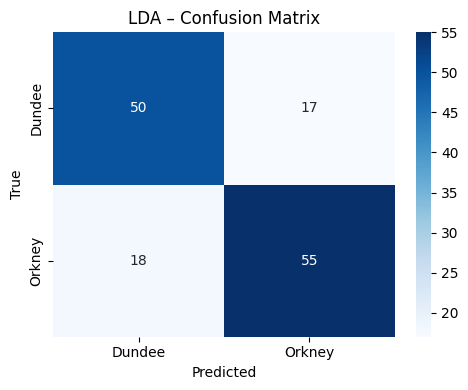

  Confusion matrix saved → /content/drive/MyDrive/3Dmodels/lda_cm.png

MODEL: FCNN
  Test accuracy: 0.8000

Classification report:
              precision    recall  f1-score   support

      Dundee     0.8000    0.7761    0.7879        67
      Orkney     0.8000    0.8219    0.8108        73

    accuracy                         0.8000       140
   macro avg     0.8000    0.7990    0.7993       140
weighted avg     0.8000    0.8000    0.7998       140



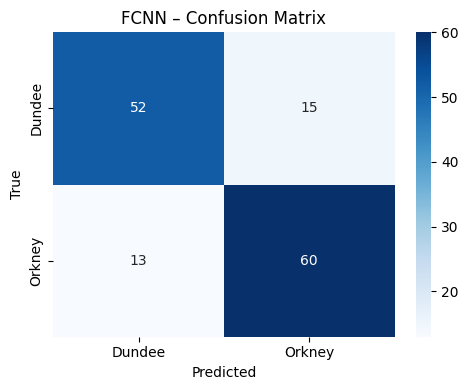

  Confusion matrix saved → /content/drive/MyDrive/3Dmodels/fcnn_cm.png

Summary JSON saved → /content/drive/MyDrive/3Dmodels/model_summary.json


In [6]:
"""
──────────────────────────────────────────────────────────────────────────────
  CLASSIFICATION BENCHMARK
------------------------------------------------------------------------------
  • Stratified split + 5-fold Stratified Cross-Validation (CV)
  • Scaling for specific models
  • Parallel execution across models (Joblib) – no nested processes
  • Early-stopping FCNN (optional, needs TensorFlow)
  • Outputs classification reports & confusion matrices, metrics summarised in JSON
  • All fitted (trained) shallow models saved to disk (Python’s pickle)
──────────────────────────────────────────────────────────────────────────────
"""

# ──────────────────────────────────────────────────────────────────────────
# 1. Imports & reproducibility
# ──────────────────────────────────────────────────────────────────────────
import os, random, json, warnings
from pathlib import Path
from tempfile import mkdtemp

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from joblib import Parallel, delayed
from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Optional FCNN
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.callbacks import EarlyStopping
    TF_OK = True
except ImportError:
    TF_OK = False
    warnings.warn("TensorFlow not installed – FCNN model will be skipped.")

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
if TF_OK:
    tf.random.set_seed(SEED)

# ──────────────────────────────────────────────────────────────────────────
# 2. Load data and encode labels
# ──────────────────────────────────────────────────────────────────────────
CSV_PATH = Path(BASE_DIR) / "measures_origin.csv"              # ← EDIT if needed
df = pd.read_csv(CSV_PATH)

le = LabelEncoder()
y = le.fit_transform(df["Class"].values)
class_names = [str(c) for c in le.classes_]
X = df.drop(columns=["File Name", "Folder Path", "Class"]).values

# ──────────────────────────────────────────────────────────────────────────
# 3. Stratified train / test split
# ──────────────────────────────────────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED        # ← EDIT if needed
)

# ──────────────────────────────────────────────────────────────────────────
# 4. Model definitions
# ──────────────────────────────────────────────────────────────────────────
cache_dir = mkdtemp()

classifiers = {
    "rf": RandomForestClassifier(
            n_estimators=300, n_jobs=1, random_state=SEED),
    "gbm": GradientBoostingClassifier(random_state=SEED),
    "svm": Pipeline([
            ("scaler", StandardScaler()),
            ("clf",    SVC(kernel="rbf", probability=True, random_state=SEED))
           ], memory=cache_dir),
    "knn": Pipeline([
            ("scaler", StandardScaler()),
            ("clf",    KNeighborsClassifier(n_neighbors=5))
           ], memory=cache_dir),
    "lda": Pipeline([
            ("scaler", StandardScaler()),
            ("clf",    LinearDiscriminantAnalysis())
           ], memory=cache_dir)
}
if TF_OK:
    classifiers["fcnn"] = "placeholder"

MODEL_ORDER = ["rf", "gbm", "svm", "knn", "lda", "fcnn"]        # ← EDIT if needed

cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# ──────────────────────────────────────────────────────────────────────────
# 5. Worker function (runs in parallel)
# ──────────────────────────────────────────────────────────────────────────
def evaluate(name):
    """Return metrics dict for one model key."""
    if name not in classifiers:
        return {"name": name, "error": "unknown model key"}

    # ------- FCNN branch --------------------------------------------------
    if name == "fcnn":
        scaler = StandardScaler().fit(X_train)
        X_tr = scaler.transform(X_train)
        X_te = scaler.transform(X_test)

        n_features = X_tr.shape[1]
        n_classes  = len(class_names)

        tf.keras.backend.clear_session()
        fcnn = Sequential([
            Dense(64, activation="relu", input_shape=(n_features,)),
            Dense(32, activation="relu"),
            Dense(n_classes, activation="softmax")
        ])
        fcnn.compile(optimizer="adam",
                     loss="sparse_categorical_crossentropy",
                     metrics=["accuracy"])
        es = EarlyStopping(monitor="val_loss", patience=10,
                           restore_best_weights=True, verbose=0)
        fcnn.fit(X_tr, y_train,
                 epochs=200, batch_size=32,
                 validation_split=0.2, callbacks=[es], verbose=0)

        y_pred = np.argmax(fcnn.predict(X_te, verbose=0), axis=1)

        return {
            "name": "fcnn",
            "cv_mean": np.nan,
            "cv_std":  np.nan,
            "test_acc": accuracy_score(y_test, y_pred),
            "report": classification_report(
                        y_test, y_pred,
                        labels=range(len(class_names)),
                        target_names=class_names,
                        digits=4),
            "cm": confusion_matrix(y_test, y_pred, labels=range(len(class_names)))
        }

    # ------- Shallow models -------------------------------------------
    model = clone(classifiers[name])

    cv_scores = cross_val_score(
        model, X_train, y_train,
        cv=cv_splitter, scoring="accuracy", n_jobs=1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    model_path = CSV_PATH.with_name(f"{name}_model.joblib")
    joblib.dump(model, model_path)

    return {
        "name": name,
        "cv_mean": cv_scores.mean(),
        "cv_std":  cv_scores.std(ddof=1),
        "test_acc": accuracy_score(y_test, y_pred),
        "report": classification_report(
                    y_test, y_pred,
                    labels=range(len(class_names)),
                    target_names=class_names,
                    digits=4),
        "cm": confusion_matrix(y_test, y_pred, labels=range(len(class_names))),
        "model_path": model_path
    }

# ──────────────────────────────────────────────────────────────────────────
# 6. Run all models in parallel
# ──────────────────────────────────────────────────────────────────────────
results = Parallel(n_jobs=len(MODEL_ORDER), backend="loky")(
    delayed(evaluate)(m) for m in MODEL_ORDER
)

# ──────────────────────────────────────────────────────────────────────────
# 7. Display & store metrics
# ──────────────────────────────────────────────────────────────────────────
for r in results:
    if "error" in r:
        print(f"[{r['name']}] ERROR: {r['error']}")
        continue

    print("\n" + "="*65)
    print(f"MODEL: {r['name'].upper()}")
    if not np.isnan(r["cv_mean"]):
        print(f"  CV accuracy : {r['cv_mean']:.4f} ± {r['cv_std']:.4f}")
    print(f"  Test accuracy: {r['test_acc']:.4f}")
    print("\nClassification report:")
    print(r["report"])

    # Confusion-matrix heat-map
    plt.figure(figsize=(5,4))
    sns.heatmap(r["cm"],
                annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f"{r['name'].upper()} – Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    cm_img = CSV_PATH.with_name(f"{r['name']}_cm.png")
    plt.savefig(cm_img, dpi=150)
    plt.show()
    print(f"  Confusion matrix saved → {cm_img}")

# ──────────────────────────────────────────────────────────────────────────
# 8. JSON summary (allows easy comparison later)
# ──────────────────────────────────────────────────────────────────────────
summary = {r["name"]: {
            "cv_mean":  r["cv_mean"],
            "cv_std":   r["cv_std"],
            "test_acc": r["test_acc"],
            "model":    str(r.get("model_path",""))
           } for r in results if "error" not in r}

summary_path = CSV_PATH.with_name("model_summary.json")
with open(summary_path, "w", encoding="utf-8") as fp:
    json.dump(summary, fp, indent=2)
print(f"\nSummary JSON saved → {summary_path}")


# Model selection and validation procedures
The following cells offere several alternative methods to validate results, compare preformance, and refine models.

## Alternative LOO Cros-validation
This cell provides an alternative (LOOCV) validation process to the previous k-fold cross-validation. LOOCV is more computationally costly but more accurate to estimate the performance of the classification for small datasets, particluarly for linear models. It requires similar inputs than previous cells: <br>
Select the csv file with the extracted measures and the classes defined previously (line 35). <br>
Select the classifier to perform the LOOCV (line 36).


=== GBM — LOOCV EVALUATION ===

Overall LOOCV Accuracy: 0.8034

Confusion Matrix:
[[251  84]
 [ 53 309]]

Classification Report:
              precision    recall  f1-score   support

      Dundee     0.8257    0.7493    0.7856       335
      Orkney     0.7863    0.8536    0.8185       362

    accuracy                         0.8034       697
   macro avg     0.8060    0.8014    0.8021       697
weighted avg     0.8052    0.8034    0.8027       697

Accuracy for class 'Dundee': 0.7493
Accuracy for class 'Orkney': 0.8536


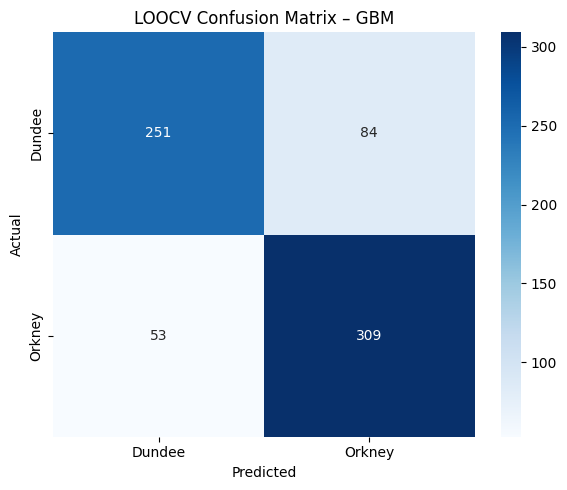

In [16]:
"""
──────────────────────────────────────────────────────────────────────────────
LOOCV EVALUATION
------------------------------------------------------------------------------
Includes:
• Scaled pipelines for distance-based models (svm, knn, lda)
• Accurate metrics: overall, per-class, full classification report
• Class presence check (never predicted classes)
• Efficient parallelised execution with cross_val_predict
──────────────────────────────────────────────────────────────────────────────
"""

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report
)

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import seaborn as sns
import matplotlib.pyplot as plt

# ────────────────────────────────────────────
# 1. Config
# ────────────────────────────────────────────
CSV_PATH = Path(BASE_DIR) / "measures_origin.csv"  # patched for portability
CLASSIFIER_NAME = "gbm"  # Options: 'rf', 'gbm', 'svm', 'knn', 'lda'    # ← EDIT if needed

# ────────────────────────────────────────────
# 2. Load and preprocess data
# ────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)

# Encode class labels
le = LabelEncoder()
y = le.fit_transform(df["Class"].values)
class_names = le.classes_

# Drop metadata columns
X = df.drop(columns=["File Name", "Folder Path", "Class"]).values

# ────────────────────────────────────────────
# 3. Classifier setup (scaling where needed)
# ────────────────────────────────────────────
from sklearn.base import clone

classifiers = {
    'rf': RandomForestClassifier(n_estimators=300, random_state=42),
    'gbm': GradientBoostingClassifier(random_state=42),
    'svm': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(random_state=42))
    ]),
    'knn': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),
    'lda': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LinearDiscriminantAnalysis())
    ])
}

if CLASSIFIER_NAME not in classifiers:
    raise ValueError(f"Unknown classifier: {CLASSIFIER_NAME}")

clf = clone(classifiers[CLASSIFIER_NAME])

# ────────────────────────────────────────────
# 4. LOOCV prediction
# ────────────────────────────────────────────
loo = LeaveOneOut()
y_pred = cross_val_predict(clf, X, y, cv=loo, n_jobs=-1)

# ────────────────────────────────────────────
# 5. Evaluation
# ────────────────────────────────────────────
print(f"\n=== {CLASSIFIER_NAME.upper()} — LOOCV EVALUATION ===")

# Overall accuracy
acc = accuracy_score(y, y_pred)
print(f"\nOverall LOOCV Accuracy: {acc:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
print(f"\nConfusion Matrix:\n{conf_matrix}")

# Classification report
report = classification_report(y, y_pred, target_names=class_names,
                               digits=4, zero_division=0)
print(f"\nClassification Report:\n{report}")

# Per-class accuracy
class_acc = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i, c_acc in enumerate(class_acc):
    print(f"Accuracy for class '{class_names[i]}': {c_acc:.4f}")

# Classes never predicted
missed = set(np.unique(y)) - set(np.unique(y_pred))
if missed:
    print(f"\n⚠ WARNING: The following classes were never predicted: "
          f"{[class_names[i] for i in missed]}")

# ────────────────────────────────────────────
# 6. Confusion matrix heatmap (optional)
# ────────────────────────────────────────────
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title(f"LOOCV Confusion Matrix – {CLASSIFIER_NAME.upper()}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


## Overfitting test

Some of the models employed can be prone to overfitting, particularly GBM. The following script is designed to tst if the results provided by these classifiers present overfitting, making their metrics unreliable. <br>
The test can also be used as an informal way to check the ideal number of RF trees  <br>
Select the csv file with the extracted measures and the classes defined previously (line 25). <br> <br>
ATENTION: if you set MODEL_KEY = "fcnn" you need to have run the classification-benchmark cell above


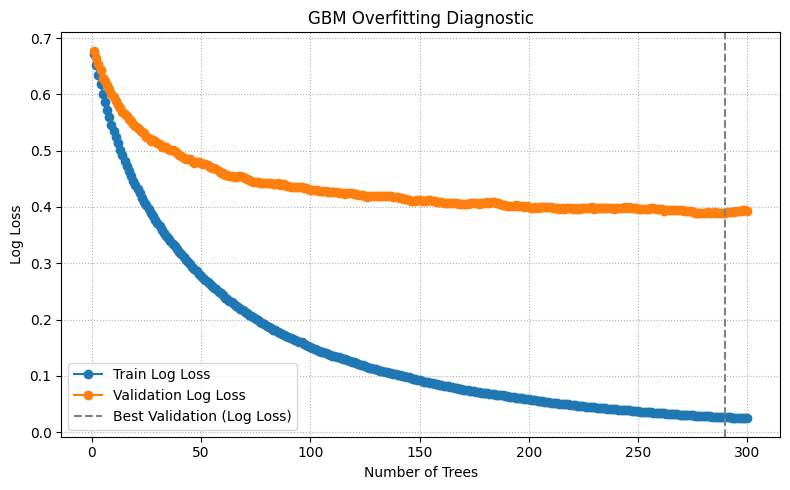


• Best point at Number of Trees = 290
• Train Log Loss: 0.0267
• Val   Log Loss: 0.3892
✅ No strong overfitting detected.


In [18]:
"""
───────────────────────────────────────────────────────────
OVERTITTING CHECK
-----------------------------------------------------------
• Loads feature CSV with a 'Class' column
• Lets you pick any classifier key used in the classifier benchmark
• Trains it in incremental fashion appropriate to the algorithms
• Plots training vs. validation loss / accuracy
───────────────────────────────────────────────────────────
"""

# ────────────────────────────────────────────
# 0. Imports and reproducibility
# ────────────────────────────────────────────
from pathlib import Path
import warnings, random, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, accuracy_score
from sklearn.base import clone

warnings.filterwarnings("ignore", category=UserWarning)
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ────────────────────────────────────────────
# 1. CONFIGURATION
# ────────────────────────────────────────────
CSV_PATH        = Path(BASE_DIR) / "measures_origin.csv"  # ← EDIT if needed
VALIDATION_SIZE = 0.2
MODEL_KEY       = "gbm"      # ← EDIT if needed with "gbm", "rf", "svm", "knn", "lda", "fcnn"

# shared hyper-parameters
N_ESTIMATORS  = 300     # for GBM total trees, for RF max trees
LEARNING_RATE = 0.05    # GBM shrinkage parameter
RF_STEP       = 25      # how many trees to add per loop when MODEL_KEY == 'rf'. Must be ≤ than N_ESTIMATORS
SUBSET_STEPS  = 10      # # of fractional train-subsample steps
FCNN_EPOCHS   = 60
BATCH_SIZE    = 32

# ────────────────────────────────────────────
# 2. Load and prepare data
# ────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)
if "Class" not in df.columns:
    raise ValueError("CSV must contain a 'Class' column")

y = LabelEncoder().fit_transform(df["Class"])
X = df.drop(columns=["File Name", "Folder Path", "Class"], errors="ignore")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=VALIDATION_SIZE, stratify=y, random_state=SEED
)

n_classes = np.unique(y_train).size
input_dim = X_train.shape[1]

# ────────────────────────────────────────────
# 3. Obtain the estimator
# ────────────────────────────────────────────
def _default_fcnn(dim, n_cls):
    """Compact fallback if build_fcnn_model() isn't present."""
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    model = Sequential([
        Dense(128, activation="relu", input_shape=(dim,)),
        BatchNormalization(), Dropout(0.3),
        Dense(64,  activation="relu"),
        BatchNormalization(), Dropout(0.3),
        Dense(n_cls, activation="softmax")
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

MODELS = dict(
    gbm = GradientBoostingClassifier(
            n_estimators=N_ESTIMATORS,
            learning_rate=LEARNING_RATE,
            random_state=SEED),
    rf  = RandomForestClassifier(
            n_estimators=RF_STEP,
            warm_start=True,
            random_state=SEED),
    svm = SVC(kernel="rbf", probability=True,
              C=10, gamma="scale", random_state=SEED),
    knn = KNeighborsClassifier(n_neighbors=5),
    lda = LinearDiscriminantAnalysis()
)

if MODEL_KEY == "fcnn":
    try:
        model = build_fcnn_model(input_dim=input_dim, n_classes=n_classes)
    except NameError:
        print("⚠️  build_fcnn_model() not found – using default FCNN.")
        model = _default_fcnn(input_dim, n_classes)
else:
    if MODEL_KEY not in MODELS:
        raise KeyError(f"Unknown MODEL_KEY '{MODEL_KEY}' – choose from "
                       f"{list(MODELS) + ['fcnn']}")
    model = MODELS[MODEL_KEY]

# ────────────────────────────────────────────
# 4. Incremental training / evaluation
# ────────────────────────────────────────────
def _has_proba(est):
    return hasattr(est, "predict_proba")

train_scores, val_scores = [], []
x_axis, x_label = None, None
metric_name = "Log Loss" if _has_proba(model) else "Accuracy"

# ---- 4a. Gradient Boosting ----------------------------------------------------
if MODEL_KEY == "gbm":
    model.fit(X_train, y_train)
    for y_tr_p, y_va_p in zip(
        model.staged_predict_proba(X_train),
        model.staged_predict_proba(X_val)
    ):
        train_scores.append(log_loss(y_train, y_tr_p))
        val_scores.append(log_loss(y_val,   y_va_p))
    x_axis = np.arange(1, N_ESTIMATORS + 1)
    x_label = "Number of Trees"

# ---- 4b. Random-Forest (warm_start) ------------------------------------------
elif MODEL_KEY == "rf":
    tree_counts = list(range(RF_STEP, N_ESTIMATORS + 1, RF_STEP))
    for n in tree_counts:
        model.set_params(n_estimators=n)
        model.fit(X_train, y_train)
        train_p = model.predict_proba(X_train)
        val_p   = model.predict_proba(X_val)
        train_scores.append(log_loss(y_train, train_p))
        val_scores.append(log_loss(y_val,   val_p))
    x_axis, x_label = tree_counts, "Number of Trees"

# ---- 4c. FCNN (Keras) ---------------------------------------------------------
elif MODEL_KEY == "fcnn":
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=FCNN_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=0
    )
    train_scores = history.history["loss"]
    val_scores   = history.history["val_loss"]
    x_axis = np.arange(1, FCNN_EPOCHS + 1)
    x_label = "Epoch"

# ---- 4d. Batch learners (SVM / k-NN / LDA) -----------------------------------
else:
    fractions = np.linspace(0.1, 1.0, SUBSET_STEPS)
    rng = np.random.RandomState(SEED)
    for frac in fractions:
        # class-stratified subsample of training set
        idx = np.hstack([
            rng.choice(np.flatnonzero(y_train == c),
                       size=max(1, int(frac * sum(y_train == c))),
                       replace=False)
            for c in np.unique(y_train)
        ])
        X_sub, y_sub = X_train.iloc[idx], y_train[idx]
        clf = clone(model).fit(X_sub, y_sub)

        if _has_proba(clf):
            train_p = clf.predict_proba(X_sub)
            val_p   = clf.predict_proba(X_val)
            train_scores.append(log_loss(y_sub, train_p))
            val_scores.append(log_loss(y_val,  val_p))
        else:
            train_scores.append(accuracy_score(y_sub, clf.predict(X_sub)))
            val_scores.append(accuracy_score(y_val, clf.predict(X_val)))

    x_axis, x_label = fractions, "Train-set fraction"

# ────────────────────────────────────────────
# 5. Plot learning curves
# ────────────────────────────────────────────
plt.figure(figsize=(8, 5))
plt.plot(x_axis, train_scores, marker="o", label=f"Train {metric_name}")
plt.plot(x_axis, val_scores,   marker="o", label=f"Validation {metric_name}")
best_idx = (np.argmin if metric_name == "Log Loss" else np.argmax)(val_scores)
plt.axvline(x_axis[best_idx], color="gray", linestyle="--",
            label=f"Best Validation ({metric_name})")
plt.title(f"{MODEL_KEY.upper()} Overfitting Diagnostic")
plt.xlabel(x_label); plt.ylabel(metric_name)
plt.legend(); plt.grid(True, linestyle=":"); plt.tight_layout(); plt.show()

# ────────────────────────────────────────────
# 6. Print summary
# ────────────────────────────────────────────
best_val   = val_scores[best_idx]
best_train = train_scores[best_idx]
print(f"\n• Best point at {x_label} = {x_axis[best_idx]}")
print(f"• Train {metric_name}: {best_train:.4f}")
print(f"• Val   {metric_name}: {best_val:.4f}")

if metric_name == "Log Loss":
    overfit = val_scores[-1] > best_val + 0.01
else:  # accuracy
    overfit = val_scores[-1] < best_val - 0.01

print("✅ No strong overfitting detected."
      if not overfit else
      "⚠️  Validation performance worsens after the best point — possible overfitting.")
